Import statements from Matt

In [1]:
import astropy
from astropy.io import fits
import numpy as np 
import textwrap
import matplotlib.pyplot as plt
import os, sys 
import importlib
import glob
from tqdm import tqdm


from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.wcs import WCS

import fitsio


# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import known
import downloader

importlib.reload(known)
importlib.reload(downloader)


<module 'downloader' from '/Users/matthewjohnpayne/Envs/shifty/shifty/downloader.py'>

In [2]:
import astropy 
astropy.__version__ , astropy.__path__

('4.0',
 ['/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/astropy'])

In [3]:
# Some notes on which camera/ccd/etc we expect Sedna to be in 
# - These came from inputing 57.136 7.6549 into lightkurve's tess-cut/tess-search function 
camera = 1 
ccd = 4
col, row = 1550, 1101

In [4]:
importlib.reload(known)
K = known.Known()

# These are the values from JPL at hourly intervals
JD_, RA_, Dec_  = K._radec_for_sedna()
for t,r,d in zip(JD_[:2], RA_[:2], Dec_[:2]):
    print(t,r,d)
print()

# Plot the positions across the course of the November 2019 (Sector-5) period  
RA_, Dec_ = K._interpolate_radec_for_sedna(JD_)
#plt.plot(JD_, RA_ , '.')
#plt.plot(JD_, Dec_ , '.')

2458436.5 57.1364 7.65498
2458436.541666667 57.13601 7.65487



In [5]:
import eleanor

I'm going to pick a random target where near Sedna is expected to be to get the timestamps and quality flags for sector 5. If you already have these, just set them as variables instead.

In [6]:
star = eleanor.Source(tic=468899671, sector=5) # for sedna
#star = eleanor.Source(tic=649903630, sector=5) # for 101

INFO: Found cached file /Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_bkg.fits with expected size 73658880. [astroquery.query]
INFO: Found cached file /Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc.fits with expected size 147421440. [astroquery.query]
INFO: Found cached file /Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4_tess_v2_pm.txt with expected size 222713. [astroquery.query]


In [7]:
data = eleanor.TargetData(star)

Set DATE-BEG to '2018-11-15T11:38:52.334' from MJD-BEG'. [astropy.wcs.wcs]


In [8]:
data.time

array([1437.99575975, 1438.01659318, 1438.03742662, ..., 1464.22447545,
       1464.24530799, 1464.26614053])

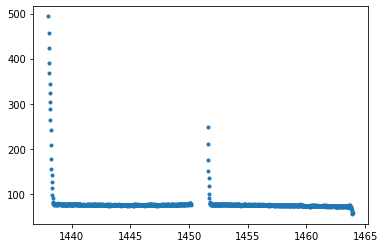

In [80]:
q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q], '.')

In [10]:
times = data.time[q] + 0.0

In [11]:
def get_sedna_shifts(tvals):
    x, y = [], []
    ralist, declist = [], []
    times = []
    for i in range(len(tvals)):
        jd = 2457000 + tvals[i]
        ra, dec = known.Known()._interpolate_radec_for_sedna(jd)
        crd = SkyCoord(ra, dec, unit='deg')
        #pixel = WCS(hdr).world_to_pixel(crd)
        #x.append(int(pixel[0]))
        #y.append(int(pixel[1]))
        ralist.append(ra)
        declist.append(dec)
        times.append(jd)
    return np.array(tuple(zip(x, y))), np.array(tuple(zip(ralist, declist))), times

def get_101_shifts(tvals):
    x, y = [], []
    ralist, declist = [], []
    times = []
    for i in range(len(tvals)):
        jd = 2457000 + tvals[i]
        ra, dec = known.Known()._interpolate_radec_for_101583(jd)
        crd = SkyCoord(ra, dec, unit='deg')
        #pixel = WCS(hdr).world_to_pixel(crd)
        #x.append(int(pixel[0]))
        #y.append(int(pixel[1]))
        ralist.append(ra)
        declist.append(dec)
        times.append(jd)
    return np.array(tuple(zip(x, y))), np.array(tuple(zip(ralist, declist))), times

let's get predicted RA and Dec for Sedna at each cadence

In [12]:
_, locs, t_vals = get_sedna_shifts(times)

In [13]:
locs[300]

array([57.05547879,  7.63669815])

In [14]:
from tqdm import tnrange
from tess_stars2px import tess_stars2px_function_entry


And then we'll use Chris Burke's tess-point tool to convert these coordinates at each cadence to a pixel position at each cadence.

In [15]:
x, y = [], []

for j in tnrange(len(locs)):

    ra = locs[j,0]
    dec = locs[j,1]
    ticid = 8675309
    outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, \
        outColPix, outRowPix, scinfo = tess_stars2px_function_entry(
                ticid, ra, dec)

    x.append(outColPix[0])
    y.append(outRowPix[0])
    

/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


sedna, x0,y0 =  1543.0725433957641 1103.0246948673343
sedna, x0,y0 =  29 77


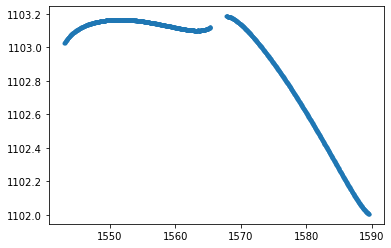

In [280]:
plt.plot(x,y, '.')
print('sedna, x0,y0 = ' , x[0], y[0])
a1 = np.round(np.array(x)-1588 + 148/2, 0).astype(int)
a2 = np.round(np.array(y)-1078 + 104/2, 0).astype(int)
print('sedna, x0,y0 = ' , a1[0], a2[0])

Let's get a postcard that covers this part of the sky

In [17]:
data.post_obj

eleanor postcard (/Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc.fits)

In [18]:
from astropy.io import fits

In [20]:
a = fits.open('/Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc.fits')
bkg_ = fits.open('/Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_bkg.fits')


And then let's use it. At each cadence, draw a 27x27 region from the postcard centered on the expected position of Sedna. We'll subtract off the median of the 100 cadences on either side of the postcard frame to use as a median model of what the stars are doing. Then stack up these shifted frames. For coding convenience/laziness I'm only selecting the region when this entire TPF would fall onto the postcard, and excluding the first and last 100 frames for median calculations, but there's no reason we couldn't do both of those more properly.

We could also pre-compute the median frames and do that calculation much more quickly than I'm doing it here.

It would also be good to split up the two orbits, right now the last 100 frames of the first orbit include median information from the first 100 cadences of the second orbit, where we know the pointing is different.

In [317]:
pc_x_mid = 1588
pc_y_mid = 1078

pc_x_wid = 74 #148/2
pc_y_wid = 52 #104/2

pc_x_0 = pc_x_mid - pc_x_wid
pc_y_0 = pc_y_mid - pc_y_wid

pc_x_1 = pc_x_mid + pc_x_wid
pc_y_1 = pc_y_mid + pc_y_wid

a1_ = np.array( [ int(np.round((_-pc_x_mid) + pc_x_wid, 0)) for _ in x ])
a2_ = np.array( [ int(np.round((_-pc_y_mid) + pc_y_wid, 0)) for _ in y ])


In [344]:
size = len(a[2].data[q])
runmed = np.zeros(a[2].data[q].shape)
medsub = np.zeros(a[2].data[q].shape)
output = np.zeros((size, 53,53))
#bkgput = np.zeros((size, 53,53))

for i in tnrange(100, size-100):

    a1 = a1_[i]
    a2 = a2_[i]
        
    if ((a1 > 27) and (a1 < 121) and (a2 > 27) and (a2 < 121)):  

        runmed[i] = np.nanmedian(a[2].data[q][i-100:i+100], axis=(0))
        medsub[i] = a[2].data[q][i] - runmed[i]

        output[i] = medsub[i, a2-26:a2+27, a1-26:a1+27] 
        
        


/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


# WANT TO MASK OUT THE AREAS THAT HAVE ANY EXCESS SIGNAL IN THE RAW  



In [477]:
# WANT TO MASK OUT THE AREAS THAT HAVE ANY EXCESS SIGNAL IN THE RAW  
aggressively_masked_raw_data = np.zeros( a[2].data[q].shape )
for i in range(a[2].data[q].shape[0]):
    # Find where there is any even remotely high signal 
    indicees  = np.abs(a[2].data[q][i]) > 10.  
    # Mask out the high signals 
    masked = a[2].data[q][i]
    masked[indicees] = 0 
    # Save the masked data 
    aggressively_masked_raw_data[i] = masked
aggressively_masked_raw_data.shape 

(1162, 104, 148)

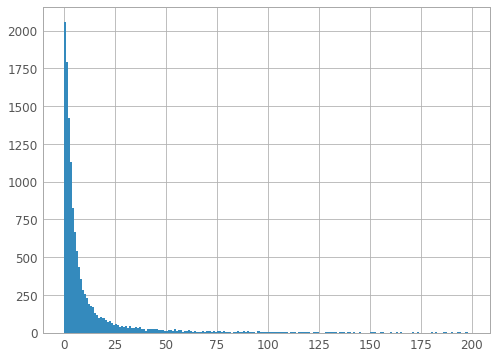

In [478]:
_ = plt.hist(a[2].data[q][100].flatten() , bins=np.arange(0,200,1) )

In [479]:
size = len(aggressively_masked_raw_data)
aggressively_masked_runmed = np.zeros(aggressively_masked_raw_data.shape)
aggressively_masked_medsub = np.zeros(aggressively_masked_raw_data.shape)

for i in tnrange(100, size-100):

    a1 = a1_[i]
    a2 = a2_[i]
        
    if ((a1 > 27) and (a1 < 121) and (a2 > 27) and (a2 < 121)):  

        aggressively_masked_runmed[i] = np.nanmedian(aggressively_masked_raw_data[i-100:i+100], axis=(0))
        aggressively_masked_medsub[i] = aggressively_masked_raw_data[i] - aggressively_masked_runmed[i]        
        


/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


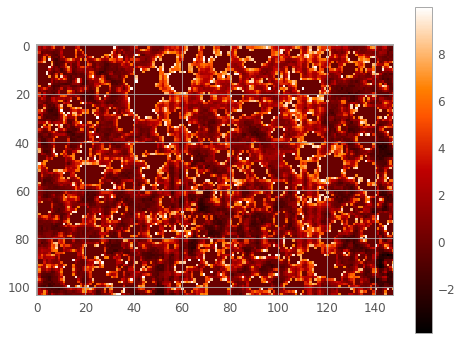

In [480]:
plt.imshow(aggressively_masked_raw_data[100])
plt.colorbar()

In [267]:
print(' data shape ', a[2].data[q].shape)
print(' output shape ', output.shape)
print(' runmed shape ', runmed.shape)
print( ' output-sum ' ,np.sum(output))
print( ' runmed-sum ' ,np.sum(runmed))


 data shape  (1162, 104, 148)
 output shape  (1162, 53, 53)
 runmed shape  (1162, 104, 148)
 output-sum  175733.0269317627
 runmed-sum  422784297.4356766


In [268]:
dataSlice = 150 


### Quick look at a postcard 

extent =  [1514, 1662, 1026, 1130]
mid: (+74,+ 52) ==>>  (1588, 1078)
sedna:          ==>>  1543 1103
 
	 * output-sum  0.0


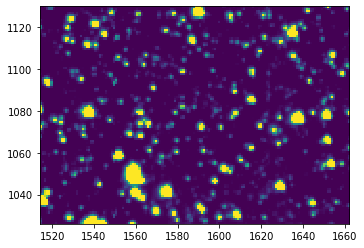

In [337]:
extent = [pc_x_0,pc_x_1,pc_y_0,pc_y_1]
print('extent = ', extent)
plt.imshow(a[2].data[q][dataSlice], vmin=4.00, vmax=100.00, origin='lower', extent=extent)

print( 'mid: (+74,+ 52) ==>> ' , (pc_x_mid, pc_y_mid) )
print( 'sedna:          ==>> ' , a1_[0]+pc_x_0,a2_[0]+pc_y_0)
print( ' \n\t * output-sum ' ,np.sum(output))


### Quick zoom-in around the expected region for Sedna

xlims= (1562, 1615)  , ylims= (1052, 1105)
sedna:          ==>>  1543 1103
 
	 * output-sum  0.0


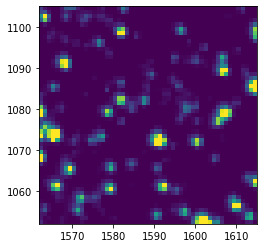

In [338]:
extent = [pc_x_0,pc_x_1,pc_y_0,pc_y_1]

xlims = pc_x_mid-26, pc_x_mid+27 # a1_[0] -26 , a1_[0] +27
ylims = pc_y_mid-26, pc_y_mid+27 #a2_[0] -26 , a2_[0] +27
plt.imshow(a[2].data[q][dataSlice], vmin=4.00, vmax=100.00, origin='lower', extent=extent)
plt.xlim(xlims)
plt.ylim(ylims)
print( 'xlims=',xlims, ' , ylims=',ylims)
print( 'sedna:          ==>> ' , a1_[0]+pc_x_0,a2_[0]+pc_y_0)
print( ' \n\t * output-sum ' ,np.sum(output))


### Running Median around the expected region for Sedna

1.0 17238.671936035156 0.43996146824372767 3.547905988633202
origin:   (0,0) ==>>  (1588, 1078)
sedna:          ==>>  33 77
 
	 * output-sum  0.0


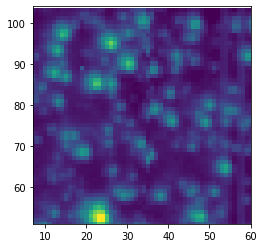

In [339]:
import copy 
dataArray  = copy.deepcopy(runmed[dataSlice])
dataArray -= np.min(dataArray) - 1
vmin, vmax = np.nanpercentile( np.log10(dataArray ) , [1., 99.9] )
print(np.min(dataArray) , np.max(dataArray), vmin, vmax ) 

plt.imshow( np.log10(dataArray ) , vmin=vmin, vmax=vmax, origin='lower')
plt.xlim(a1-26, a1+27)
plt.ylim(a2-26, a2+27)
print( 'origin:   (0,0) ==>> ' , (1588,1078) )
print( 'sedna:          ==>> ' , a1,a2)
print( ' \n\t * output-sum ' ,np.sum(output))


### Subtracted data around the expected region for Sedna

-3.509033203125 2.95556640625 -0.004199981689453125
(104, 148) 2
-2.4464340209960938 2.95556640625 -0.004055023193359375
 
	 * output-sum  175733.0269317627


/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


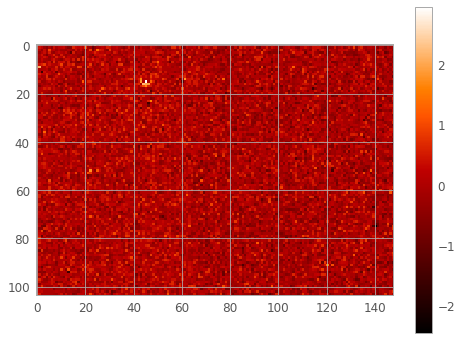

In [384]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

dataSlice = 250
dataArray  = copy.deepcopy(medsub[dataSlice])
print(np.nanmin(dataArray) ,np.nanmax(dataArray) ,np.nanmedian(dataArray)  )


indicees = np.log10(np.abs(dataArray)) > 0.5  # 2*np.nanmedian(dataArray)
print(indicees.shape, np.sum(indicees) ) 
masked = copy.deepcopy(dataArray)
masked[indicees] = 0
print(np.nanmin(masked) ,np.nanmax(masked) ,np.nanmedian(masked)  )


#dataArray  = dataArray[a2-26:a2+27, a1-26:a1+27] 
#dataArray -= np.min(dataArray) - 1
#vmin, vmax = np.nanpercentile( np.log10(dataArray ) , [1., 99.9] )
#print(np.min(dataArray) , np.max(dataArray), vmin, vmax ) 

plt.imshow(  masked   )#, vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar()
print( ' \n\t * output-sum ' ,np.sum(output))


Text(0.5, 1.0, 'subtracted slice')

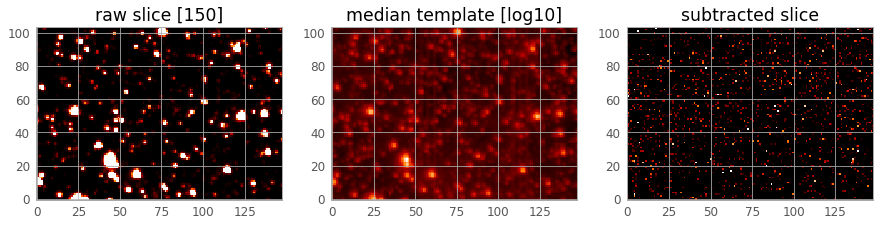

In [505]:
# Make comparison plots 
#from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 3,figsize=(15,5))

dataSlice = 150 

# single slice from data 
ax[0].imshow( a[2].data[q][dataSlice], origin='lower', vmin=4.00, vmax=100.00)
ax[0].set_title('raw slice [%d]' % dataSlice)

# template
dataArray  = copy.deepcopy(runmed[dataSlice])
dataArray -= np.min(dataArray) - 1
#vmin, vmax = np.nanpercentile( np.log10(dataArray ) , [1., 99.9] )
ax[1].imshow( np.log10(dataArray) , origin='lower' )#, vmin=vmin, vmax=vmax, origin='lower')
ax[1].set_title('median template [log10]')

# single slice from subtracted 
dataArray  = copy.deepcopy(medsub[dataSlice])
ax[2].imshow(  (np.abs(dataArray) )  , origin='lower', vmin=0.01, vmax=1.0)
ax[2].set_title('subtracted slice')



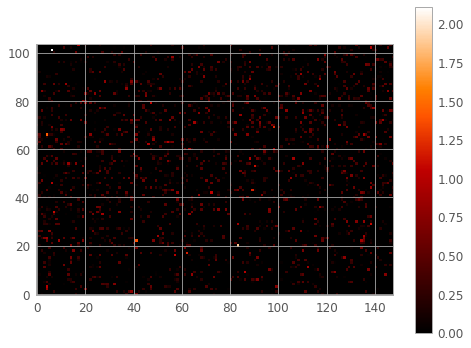

In [502]:
plt.imshow(  (np.abs(dataArray) )  , origin='lower')#, vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar()

1061 35 77
1.0 23.326416015625 1.2591441406633193 1.3152895448172868
 
	 * output-sum  175733.0269317627


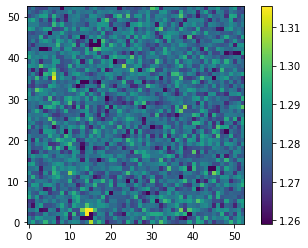

In [273]:
a1 = int(np.round((x[dataSlice]-1588) + 148/2, 0))
a2 = int(np.round((y[dataSlice]-1078) + 104/2, 0))
print(i, a1, a2)




dataArray  = copy.deepcopy(a[2].data[q][dataSlice] - runmed[dataSlice])
dataArray  = dataArray[a2-26:a2+27, a1-26:a1+27] 
dataArray -= np.min(dataArray) - 1
vmin, vmax = np.nanpercentile( np.log10(dataArray ) , [1., 99.9] )
print(np.min(dataArray) , np.max(dataArray), vmin, vmax ) 
plt.imshow(  np.log10(dataArray) , vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar()
#plt.xlim(a1-26, a1+27)
#plt.ylim(a2-26, a2+27)
#print( 'origin:   (0,0) ==>> ' , (1588,1078) )
#print( 'sedna:          ==>> ' , a1,a2)
print( ' \n\t * output-sum ' ,np.sum(output))


1.0 23.326416015625 1.2591441406633193 1.3152895448172868
sedna:          ==>>  26 26
 
	 * output-sum  175733.0269317627


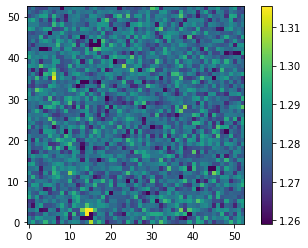

In [350]:
import copy 
dataArray  = copy.deepcopy(output[dataSlice])
dataArray -= np.min(dataArray) - 1
vmin, vmax = np.nanpercentile( np.log10(dataArray ) , [1., 99.9] )
print(np.min(dataArray) , np.max(dataArray), vmin, vmax ) 
plt.imshow(  np.log10(dataArray) , vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar()
print( 'sedna:          ==>> ' , 26,26 )
print( ' \n\t * output-sum ' ,np.sum(output))


In [264]:
i = 3;
(i, a2[i]-26 ,a2[i]+27, a1[i]-26,a1[i]+27)

(3, 491, 544, 3, 56)

In [277]:
print(a1)
print(a2)
dataArray = np.zeros(runmed.shape)

for i in range(dataArray.shape[0]): 
    print('\n', i, a1[i], a2[i])
    dataArray[i] = copy.deepcopy(a[2].data[q][i] - runmed[i])#[a2[i]-26:a2[i]+27, a1[i]-26:a1[i]+27]
    print('newarray ... ',np.min(dataArray[i]), np.max(dataArray[i]), np.sum(dataArray[i]))
    print('output   ... ',np.min(output[i]), np.max(output[i]), np.sum(output[i]))

'''
for i in tnrange(100, size-100):

    a1 = a1_[i]
    a2 = a2_[i]
        
    if ((a1 > 27) and (a1 < 121) and (a2 > 27) and (a2 < 121)):  

        runmed[i] = np.nanmedian(a[2].data[q][i-100:i+100], axis=(0))
        medsub    = a[2].data[q][i] - runmed[i]

        output[i] = medsub[a2-26:a2+27, a1-26:a1+27] 
'''


[29 29 29 ... 75 75 76]
[77 77 77 ... 76 76 76]

 0 29 77
newarray ...  -81.19482421875 17628.46484375 641165.5786743164
output   ...  0.0 0.0 0.0

 1 29 77
newarray ...  -75.85089111328125 17629.869140625 619550.7590026855
output   ...  0.0 0.0 0.0

 2 29 77
newarray ...  -69.9444580078125 17626.544921875 594084.406829834
output   ...  0.0 0.0 0.0

 3 29 77
newarray ...  -63.142822265625 17633.201171875 583135.7473754883
output   ...  0.0 0.0 0.0

 4 29 77
newarray ...  -57.203582763671875 17632.505859375 581047.3961181641
output   ...  0.0 0.0 0.0

 5 29 77
newarray ...  -53.073944091796875 17631.55859375 571918.2632141113
output   ...  0.0 0.0 0.0

 6 29 77
newarray ...  -46.856292724609375 17630.341796875 576588.676574707
output   ...  0.0 0.0 0.0

 7 29 77
newarray ...  -44.29901123046875 17624.40625 559398.9941101074
output   ...  0.0 0.0 0.0

 8 29 77
newarray ...  -40.75592041015625 17623.818359375 546438.2090454102
output   ...  0.0 0.0 0.0

 9 29 77
newarray ...  -38.31028747

newarray ...  -3.450592041015625 17420.787109375 440684.7808685303
output   ...  0.0 0.0 0.0

 85 32 77
newarray ...  -3.520294189453125 17432.67578125 441460.5030670166
output   ...  0.0 0.0 0.0

 86 32 77
newarray ...  -3.3956146240234375 17432.490234375 440858.8949890137
output   ...  0.0 0.0 0.0

 87 32 77
newarray ...  -3.2147369384765625 17411.724609375 441243.55822753906
output   ...  0.0 0.0 0.0

 88 32 77
newarray ...  -3.207489013671875 17429.55078125 441601.3376159668
output   ...  0.0 0.0 0.0

 89 33 77
newarray ...  -3.41094970703125 17426.513671875 441639.5811767578
output   ...  0.0 0.0 0.0

 90 33 77
newarray ...  -3.5895843505859375 17405.5703125 440696.2805633545
output   ...  0.0 0.0 0.0

 91 33 77
newarray ...  -3.8664703369140625 17408.505859375 440425.864654541
output   ...  0.0 0.0 0.0

 92 33 77
newarray ...  -3.475860595703125 17411.423828125 440970.64179992676
output   ...  0.0 0.0 0.0

 93 33 77
newarray ...  -2.8622894287109375 17402.728515625 442429.6811676

newarray ...  -40.29638671875 37.813682556152344 -564.1801071166992
output   ...  -18.1181640625 4.208251953125 -244.90570068359375

 151 35 77
newarray ...  -29.7474365234375 36.32173156738281 181.16818237304688
output   ...  -7.95654296875 8.4189453125 -143.3301544189453

 152 35 77
newarray ...  -28.080810546875 40.96759033203125 147.3536605834961
output   ...  -4.66412353515625 7.261474609375 90.43046569824219

 153 35 77
newarray ...  -82.3828125 45.59461975097656 -1355.190315246582
output   ...  -19.0126953125 11.10205078125 -249.24359130859375

 154 35 77
newarray ...  -51.298828125 45.53363800048828 -679.8316497802734
output   ...  -15.080078125 18.714691162109375 44.10437774658203

 155 35 77
newarray ...  -51.453125 42.653656005859375 145.33287048339844
output   ...  -19.65771484375 42.653656005859375 124.78773498535156

 156 35 77
newarray ...  -47.029296875 36.03083038330078 -390.8509826660156
output   ...  -10.903564453125 36.03083038330078 0.07685089111328125

 157 35 77


newarray ...  -10.73828125 23.546875 -571.399658203125
output   ...  -1.8194580078125 6.0517578125 -14.249092102050781

 213 38 77
newarray ...  -6.666015625 6.0966796875 -918.4597396850586
output   ...  -2.381103515625 4.40234375 -195.8871078491211

 214 38 77
newarray ...  -8.41650390625 11.763671875 572.2569427490234
output   ...  -1.9083480834960938 5.980712890625 93.9024658203125

 215 38 77
newarray ...  -20.0966796875 4.796630859375 -272.2906265258789
output   ...  -3.939208984375 1.85296630859375 -130.65019989013672

 216 38 77
newarray ...  -5.75390625 4.873046875 537.6032485961914
output   ...  -2.7294921875 2.337646484375 326.29888916015625

 217 38 77
newarray ...  -12.0126953125 14.54833984375 -469.3041763305664
output   ...  -5.96484375 8.88671875 -200.84264373779297

 218 38 77
newarray ...  -5.4384765625 7.5458984375 -253.39527130126953
output   ...  -4.01708984375 2.9140625 64.98957824707031

 219 38 77
newarray ...  -11.951171875 10.099609375 -875.1028137207031
output

newarray ...  -4.97119140625 25.958251953125 535.5270385742188
output   ...  -3.97509765625 3.1962890625 95.84749603271484

 275 40 77
newarray ...  -4.9541015625 23.5340576171875 441.9980163574219
output   ...  -2.873046875 1.3295669555664062 123.70013427734375

 276 40 77
newarray ...  -5.73486328125 25.228515625 1306.3685836791992
output   ...  -2.14849853515625 7.7470703125 371.67127227783203

 277 40 77
newarray ...  -7.5244140625 24.2606201171875 369.3804016113281
output   ...  -1.82989501953125 5.43896484375 115.76030731201172

 278 40 77
newarray ...  -2.443359375 24.443359375 350.25013732910156
output   ...  -1.135101318359375 3.384765625 17.120315551757812

 279 40 77
newarray ...  -8.3046875 23.6622314453125 441.509033203125
output   ...  -2.86669921875 4.599609375 119.12325286865234

 280 40 77
newarray ...  -5.0146484375 23.7254638671875 139.46578216552734
output   ...  -3.382080078125 6.8935546875 99.41620635986328

 281 40 77
newarray ...  -11.6875 30.28662109375 441.640

newarray ...  -13.501953125 8.69921875 245.0305938720703
output   ...  -1.981201171875 2.368408203125 9.432113647460938

 335 43 77
newarray ...  -12.1553955078125 4.27734375 447.88561248779297
output   ...  -1.2825927734375 1.3958740234375 -0.6671905517578125

 336 43 77
newarray ...  -12.687255859375 5.414794921875 -417.0608596801758
output   ...  -3.938720703125 2.0137405395507812 -42.17713928222656

 337 43 77
newarray ...  -12.2169189453125 6.55078125 -1217.8642272949219
output   ...  -1.3240203857421875 3.491455078125 -232.61138153076172

 338 43 77
newarray ...  -13.1129150390625 6.4609375 -26.497360229492188
output   ...  -1.655029296875 1.452911376953125 74.5353775024414

 339 43 77
newarray ...  -14.51953125 5.364646911621094 234.46947479248047
output   ...  -4.41552734375 3.509033203125 88.20053100585938

 340 43 77
newarray ...  -14.6903076171875 8.7412109375 167.68344116210938
output   ...  -1.79486083984375 4.036865234375 34.807395935058594

 341 43 77
newarray ...  -16.9

newarray ...  -8.59716796875 15.18115234375 506.23201751708984
output   ...  -2.347412109375 3.891845703125 214.5718994140625

 400 45 77
newarray ...  -9.1063232421875 17.13720703125 308.08068084716797
output   ...  -1.18780517578125 6.28662109375 189.87354278564453

 401 45 77
newarray ...  -15.9375 31.7978515625 551.0784606933594
output   ...  -2.987548828125 4.59375 90.5420913696289

 402 45 77
newarray ...  -8.6331787109375 10.154296875 -172.63835906982422
output   ...  -6.26904296875 4.302001953125 -139.06206512451172

 403 45 77
newarray ...  -14.63671875 35.6181640625 872.0614624023438
output   ...  -4.225341796875 8.99853515625 142.18634033203125

 404 45 77
newarray ...  -7.31787109375 14.40625 -279.3292007446289
output   ...  -2.33642578125 7.2412109375 -51.446006774902344

 405 45 77
newarray ...  -14.6171875 31.7724609375 535.2381057739258
output   ...  -4.944091796875 3.45751953125 162.52619171142578

 406 45 77
newarray ...  -6.9716796875 5.97265625 917.3256759643555
out

newarray ...  -5.53125 21.21484375 -186.34938049316406
output   ...  -3.180419921875 4.57373046875 -133.7972412109375

 464 47 77
newarray ...  -7.3671875 21.2032470703125 310.2932815551758
output   ...  -7.3671875 3.614013671875 -41.80278015136719

 465 47 77
newarray ...  -18.89453125 18.6737060546875 -236.89440155029297
output   ...  -15.77978515625 5.3193359375 -102.00860595703125

 466 48 77
newarray ...  -14.739990234375 21.768798828125 981.9858856201172
output   ...  -14.739990234375 1.7763671875 104.85309600830078

 467 48 77
newarray ...  -10.6103515625 23.3441162109375 -1099.261100769043
output   ...  -10.6103515625 2.46435546875 -326.00599670410156

 468 48 77
newarray ...  -9.177734375 20.8699951171875 134.5600357055664
output   ...  -9.177734375 2.440185546875 -178.75865173339844

 469 48 77
newarray ...  -19.439453125 23.70947265625 -532.4121704101562
output   ...  -8.9130859375 4.234375 -261.7670135498047

 470 48 77
newarray ...  -9.95751953125 21.4793701171875 312.6391

newarray ...  -126.759765625 83.6572265625 750.2062835693359
output   ...  -24.26220703125 47.935546875 319.19889068603516

 529 50 77
newarray ...  -130.98681640625 95.23388671875 464.2958297729492
output   ...  -30.966552734375 50.587890625 237.482421875

 530 50 77
newarray ...  -135.25537109375 93.15234375 -274.4619903564453
output   ...  -27.680908203125 53.08837890625 80.06292724609375

 531 50 77
newarray ...  -135.15966796875 93.42431640625 1154.239860534668
output   ...  -30.774169921875 53.23046875 318.29190826416016

 532 50 77
newarray ...  -137.232421875 106.51220703125 -109.50975799560547
output   ...  -29.62646484375 57.13720703125 43.21569061279297

 533 50 77
newarray ...  -137.24462890625 99.97314453125 -538.9814300537109
output   ...  -32.0732421875 55.0068359375 38.265869140625

 534 50 77
newarray ...  -149.2509765625 101.76220703125 -621.1737060546875
output   ...  -29.904541015625 56.393310546875 110.50474548339844

 535 50 77
newarray ...  -153.330078125 108.372

newarray ...  -17.17578125 17.2822265625 279.18638610839844
output   ...  -4.93017578125 5.666015625 -169.85630798339844

 588 54 77
newarray ...  -3.986328125 18.0283203125 1370.0794525146484
output   ...  -3.486328125 4.8984375 22.959930419921875

 589 54 77
newarray ...  -21.0888671875 49.29931640625 -320.84149169921875
output   ...  -18.6357421875 11.27001953125 -434.1153793334961

 590 54 77
newarray ...  -17.47314453125 39.28564453125 2459.4710998535156
output   ...  -8.4345703125 7.2833251953125 166.36873626708984

 591 55 77
newarray ...  -13.064697265625 43.6259765625 175.4395751953125
output   ...  -10.32177734375 9.5909423828125 -210.61585235595703

 592 55 77
newarray ...  -24.4755859375 52.86767578125 766.5312042236328
output   ...  -12.10009765625 10.6883544921875 -90.94242095947266

 593 55 77
newarray ...  -44.8076171875 86.25732421875 1146.6367492675781
output   ...  -18.701171875 20.829833984375 -49.64952087402344

 594 55 77
newarray ...  -28.529296875 54.37451171875

newarray ...  -39.636474609375 79.69873046875 663.1594314575195
output   ...  -12.0302734375 14.0806884765625 -74.00652313232422

 652 57 77
newarray ...  -45.454833984375 75.47900390625 -281.0112762451172
output   ...  -14.3624267578125 14.2623291015625 -295.05413818359375

 653 57 77
newarray ...  -42.41943359375 71.5859375 1447.906509399414
output   ...  -11.88671875 14.2353515625 163.82754516601562

 654 57 77
newarray ...  -42.412109375 71.5859375 -60.093788146972656
output   ...  -12.1402587890625 12.013916015625 -92.51478576660156

 655 57 77
newarray ...  -35.2275390625 65.5478515625 365.3381881713867
output   ...  -9.4500732421875 12.1328125 -124.17122650146484

 656 57 77
newarray ...  -42.376220703125 67.59130859375 -317.2655944824219
output   ...  -13.7701416015625 13.9658203125 -166.24674224853516

 657 57 77
newarray ...  -33.539794921875 63.46044921875 410.5772705078125
output   ...  -11.333251953125 15.184326171875 -47.33881378173828

 658 57 77
newarray ...  -37.692382

newarray ...  -52.06640625 70.3037109375 -163.9352035522461
output   ...  -20.96435546875 17.4918212890625 -3.040985107421875

 716 59 77
newarray ...  -51.7021484375 66.31103515625 -1.6063079833984375
output   ...  -33.88232421875 19.40203857421875 -37.71039581298828

 717 59 77
newarray ...  -18.4034423828125 36.1171875 355.71160888671875
output   ...  -6.71929931640625 8.92138671875 -22.95738983154297

 718 59 77
newarray ...  -16.4527587890625 28.6005859375 276.13157653808594
output   ...  -4.33502197265625 7.224365234375 81.2960205078125

 719 59 77
newarray ...  -18.03076171875 27.0517578125 -383.87894439697266
output   ...  -7.44000244140625 4.613037109375 -77.3592758178711

 720 60 77
newarray ...  -15.3616943359375 36.5703125 423.40917205810547
output   ...  -5.7276611328125 3.1851806640625 85.63191986083984

 721 60 77
newarray ...  -14.896484375 22.611328125 768.9912948608398
output   ...  -3.320556640625 4.5714111328125 108.81999969482422

 722 60 77
newarray ...  -13.75854

newarray ...  -13.8681640625 16.9461669921875 704.696403503418
output   ...  -3.279296875 7.1796875 113.25389862060547

 780 62 77
newarray ...  -9.669921875 17.848876953125 312.7397003173828
output   ...  -3.62164306640625 3.610595703125 -34.48966979980469

 781 62 77
newarray ...  -7.84765625 18.11181640625 -187.14739227294922
output   ...  -2.85498046875 6.3037109375 1.318389892578125

 782 62 77
newarray ...  -9.51025390625 16.622802734375 -27.567947387695312
output   ...  -4.3016357421875 2.58935546875 -24.342933654785156

 783 62 77
newarray ...  -7.7357177734375 16.54736328125 708.3702011108398
output   ...  -1.6898193359375 5.051765441894531 174.19271850585938

 784 62 77
newarray ...  -7.31591796875 16.696533203125 -465.68768310546875
output   ...  -2.3804931640625 8.2529296875 -39.315635681152344

 785 62 77
newarray ...  -9.177001953125 18.5096435546875 470.4879608154297
output   ...  -3.25006103515625 3.4697265625 51.999839782714844

 786 62 77
newarray ...  -7.116577148437

newarray ...  -39.95263671875 47.2578125 31.600341796875
output   ...  -18.9921875 11.70587158203125 -32.223350524902344

 844 64 77
newarray ...  -30.18896484375 47.197265625 424.8747787475586
output   ...  -14.17822265625 14.57940673828125 41.720497131347656

 845 64 77
newarray ...  -31.73681640625 30.16943359375 854.5120544433594
output   ...  -14.68603515625 10.99932861328125 145.54528045654297

 846 64 77
newarray ...  -33.31494140625 44.310546875 252.57019805908203
output   ...  -18.5791015625 12.545654296875 6.2868804931640625

 847 64 77
newarray ...  -27.8447265625 50.43017578125 -416.41375732421875
output   ...  -9.05712890625 14.5611572265625 -75.55087280273438

 848 64 77
newarray ...  -35.2490234375 37.20947265625 -149.3685302734375
output   ...  -17.26806640625 9.593505859375 -100.69305419921875

 849 64 77
newarray ...  -37.052734375 39.1708984375 -346.1788330078125
output   ...  -15.951171875 12.5068359375 -58.044525146484375

 850 64 77
newarray ...  -31.193359375 46.

newarray ...  -9.921630859375 16.1259765625 448.6390151977539
output   ...  -4.40155029296875 3.12060546875 117.39495086669922

 908 67 77
newarray ...  -16.904296875 8.9541015625 54.90293884277344
output   ...  -4.1224365234375 2.1727294921875 -4.6163330078125

 909 67 77
newarray ...  -7.4095458984375 14.5078125 -465.7168655395508
output   ...  -6.16204833984375 3.30517578125 -67.38839721679688

 910 67 77
newarray ...  -11.2596435546875 13.23388671875 51.143829345703125
output   ...  -3.806640625 2.3623046875 22.96715545654297

 911 67 77
newarray ...  -9.0283203125 12.41796875 -83.84886169433594
output   ...  -3.12115478515625 4.635986328125 -0.9431915283203125

 912 67 77
newarray ...  -11.130859375 12.21728515625 274.2343292236328
output   ...  -5.849609375 2.8721923828125 70.50090789794922

 913 67 77
newarray ...  -10.3829345703125 23.583984375 621.0032653808594
output   ...  -4.41339111328125 5.5234375 86.76984405517578

 914 67 77
newarray ...  -11.39794921875 9.7961959838867

newarray ...  -12.5068359375 15.24755859375 -414.1348190307617
output   ...  -11.302734375 6.46221923828125 -144.87106323242188

 970 69 76
newarray ...  -7.1435546875 10.4375 376.56714630126953
output   ...  -6.36181640625 3.14495849609375 -11.616897583007812

 971 69 76
newarray ...  -15.3671875 19.2841796875 333.78141021728516
output   ...  -4.83251953125 6.80682373046875 -11.943565368652344

 972 69 76
newarray ...  -13.296875 15.3511962890625 342.21256256103516
output   ...  -6.5537109375 8.3187255859375 20.7137451171875

 973 69 76
newarray ...  -6.96044921875 15.7298583984375 508.9748306274414
output   ...  -3.376953125 4.36383056640625 2.1965103149414062

 974 69 76
newarray ...  -14.279296875 18.1861572265625 -93.37054443359375
output   ...  -8.30908203125 7.8380126953125 -37.06858825683594

 975 69 76
newarray ...  -26.4404296875 22.789306640625 -511.3019485473633
output   ...  -11.75927734375 10.4403076171875 -57.65434265136719

 976 69 76
newarray ...  -12.56103515625 18.98

newarray ...  -10.4365234375 9.02099609375 -146.9296417236328
output   ...  -4.2313232421875 1.3761749267578125 -144.8073272705078

 1032 71 76
newarray ...  -8.6029052734375 17.5927734375 906.8178253173828
output   ...  -3.309814453125 4.97265625 128.30162811279297

 1033 71 76
newarray ...  -10.6259765625 14.9541015625 466.3398742675781
output   ...  -2.77813720703125 3.475341796875 -43.308135986328125

 1034 71 76
newarray ...  -16.9814453125 14.41943359375 -201.60946655273438
output   ...  -4.4993896484375 1.79376220703125 -63.991912841796875

 1035 71 76
newarray ...  -9.833984375 13.40771484375 -480.2098693847656
output   ...  -3.69281005859375 1.6259918212890625 -46.86531066894531

 1036 71 76
newarray ...  -9.491943359375 13.451171875 -454.1783447265625
output   ...  -4.44622802734375 4.97607421875 -115.97235870361328

 1037 71 76
newarray ...  -10.33837890625 15.94677734375 224.25438690185547
output   ...  -3.480224609375 2.603271484375 -21.912864685058594

 1038 71 76
newarra

newarray ...  -3.0804901123046875 15610.4453125 438333.6499633789
output   ...  0.0 0.0 0.0

 1100 73 76
newarray ...  -3.4680023193359375 15641.3095703125 437649.47189331055
output   ...  0.0 0.0 0.0

 1101 73 76
newarray ...  -3.60235595703125 15605.0810546875 437447.2953186035
output   ...  0.0 0.0 0.0

 1102 74 76
newarray ...  -2.8905029296875 15622.0615234375 438294.5549316406
output   ...  0.0 0.0 0.0

 1103 74 76
newarray ...  -3.61480712890625 15619.1484375 437665.89712524414
output   ...  0.0 0.0 0.0

 1104 74 76
newarray ...  -3.0594024658203125 15619.337890625 438012.77560424805
output   ...  0.0 0.0 0.0

 1105 74 76
newarray ...  -3.4479217529296875 15616.73046875 438097.4588165283
output   ...  0.0 0.0 0.0

 1106 74 76
newarray ...  -3.4428253173828125 15639.07421875 437512.6471557617
output   ...  0.0 0.0 0.0

 1107 74 76
newarray ...  -3.2443084716796875 15630.4521484375 437230.7380218506
output   ...  0.0 0.0 0.0

 1108 74 76
newarray ...  -3.559326171875 15622.1816406

"\nprint(' = a[2].data[q] - runmed == dataArray.shape ', dataArray.shape )\ndataArray  = np.array([ dataArray[i, a2[i]-26:a2[i]+27, a1[i]-26:a1[i]+27] for i in range(dataArray.shape[0])])\n#dataArray  = output[150:500] # dataArray[dataSlice:dataSlice+350 , a2-26:a2+27, a1-26:a1+27] \n\nprint(' = a[2].data[q] - runmed == dataArray.shape ', dataArray.shape )\nprint('     min, max', np.min(dataArray) , np.max(dataArray) )\nprint('         sum ',      np.sum(dataArray) )\n\ndataArray  = np.sum(dataArray, axis=(0))\nprint('summed shape ', dataArray.shape )\nprint('summed  min, max', np.min(dataArray) , np.max(dataArray) )\nprint('          sum ',      np.sum(dataArray) )\nvmin, vmax = np.nanpercentile( dataArray  , [1., 99.9] )\nprint('      vmin, vmax ',  vmin, vmax)\n\n_ = plt.imshow(  dataArray , vmin=vmin, vmax=vmax, origin='lower')\n#plt.xlim(a1-26, a1+27)\n#plt.ylim(a2-26, a2+27)\n#print( 'origin:   (0,0) ==>> ' , (1588,1078) )\n#print( 'sedna:          ==>> ' , a1,a2)\nplt.colorbar()

Do we see Sedna?

flux1 shape  (350, 53, 53)
  flux1 min, max  -25.26513671875 42.653656005859375
   flux1 sum  -6659.674255371094
outvar1    shape  (53, 53)
outvar1 min, max  -305.1159210205078 101.52298736572266
 outvar1 sum  -6659.674255371094
 
	 * output-sum  175733.0269317627


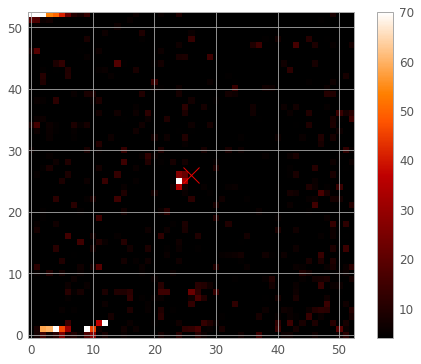

In [474]:
flux1 = output[150:500] #- bkgput[150:500] +0.0 #+ bkgput[50:500]
outvar1 = np.sum(flux1, axis=(0))

flux2 = output[800:1100] #- bkgput[800:1100] +0.0 #+ bkgput[700:1100]
outvar2 = np.sum(flux2, axis=(0))

#outvar = outvar1 + outvar2

outvar = np.sum(output, axis=(0))


plt.imshow(outvar1, vmin=4.00, vmax=70.00, origin='lower')

plt.plot(26,26, 'rx', alpha=0.9, markersize=16)

plt.colorbar()

print('flux1 shape ',      flux1.shape)
print('  flux1 min, max ', np.min(flux1) , np.max(flux1))
print('   flux1 sum ',      np.sum(flux1) )
print('outvar1    shape ', outvar1.shape)
print('outvar1 min, max ', np.min(outvar1) , np.max(outvar1))
print(' outvar1 sum ',      np.sum(outvar1) )
print( ' \n\t * output-sum ' ,np.sum(output))


Oh shit we do! And it's not a systematic like a cosmic ray, if we chunk the first and second half of the data we see it in each.

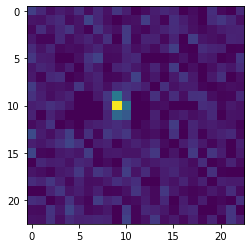

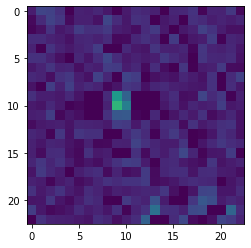

In [23]:
plt.imshow(outvar1[15:38,15:38], vmin=-10.00, vmax=100.00)
plt.show()
plt.imshow(outvar2[15:38,15:38], vmin=-10.00, vmax=100.00)
plt.show()

Now let's take a cheeky look to see if we can measure a rotation period. There's some discrepancy in the literature.

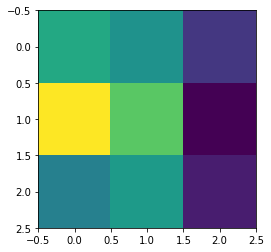

In [24]:
plt.imshow(outvar[24:27,24:27])

In [25]:
from lightkurve.lightcurve import LightCurve as LC

In [32]:
sap_flux = np.sum(output[:,24:27,24:27], axis=(1,2))

In [53]:
lk = LC(times[100:-100], sap_flux[100:-100]).remove_outliers(sigma=2.0).bin(99)

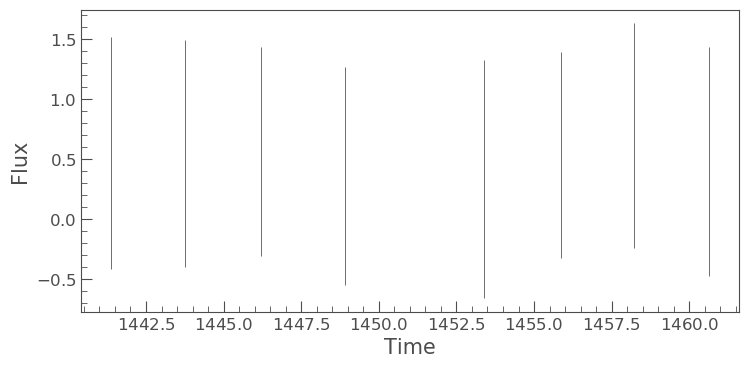

In [54]:
lk.errorbar()


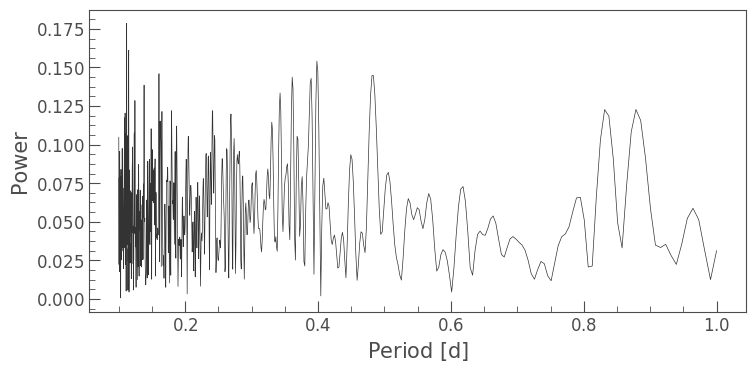

In [28]:
lk.to_periodogram(minimum_period=0.1, maximum_period=1.0).plot()


In [29]:
lk.to_periodogram(minimum_period=0.4, maximum_period=0.5).period_at_max_power

<Quantity 0.48222851 d>

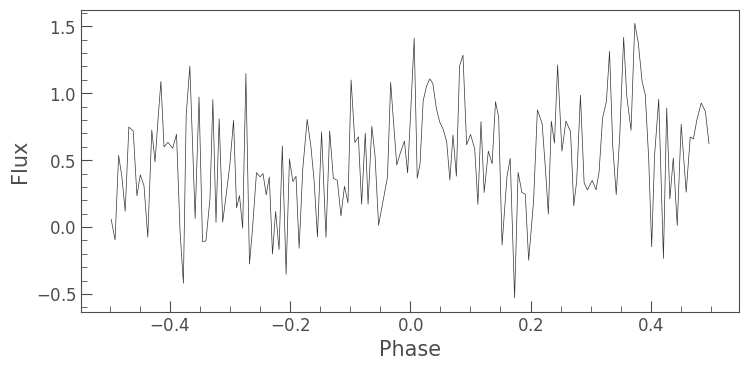

In [30]:
lk.fold(lk.to_periodogram(minimum_period=0.4, maximum_period=0.5).period_at_max_power).bin(5).plot()

That actually looks somewhat variable, but the power spectrum isn't significant, and by doing slightly different outlier removal we can get a very different result, so I don't quite believe this.

# Find the peaks in the unshifted (subtracted) image 
 - Then remove/mask the excess flux 

In [294]:
# mask which should separate pixels dominated by starlight from background
#g = np.ma.masked_where(med < np.percentile(med, 70.0), med)
#print('g.shape', g.shape)

maskedoutput = np.zeros((size, 53,53))

# Find the peaks in the starting image 
startNumber = 100 
g = np.ma.masked_where(output[startNumber] < np.percentile(output[startNumber], 70.0), output[startNumber])
mask = ~g.mask

'''
for i in tnrange(100, size-100):
    # The expected x & y positions
    a1 = int(np.round((x[i]-1588) + 148/2, 0))
    a2 = int(np.round((y[i]-1078) + 104/2, 0))
    print(a1,a2)
    sys.exit()
    if ((a1 > 27) and (a1 < 121) and (a2 > 27) and (a2 < 121)):  
        maskedoutput[i] = medsub[a2-26:a2+27, a1-26:a1+27] 
'''


'\nfor i in tnrange(100, size-100):\n    # The expected x & y positions\n    a1 = int(np.round((x[i]-1588) + 148/2, 0))\n    a2 = int(np.round((y[i]-1078) + 104/2, 0))\n    print(a1,a2)\n    sys.exit()\n    if ((a1 > 27) and (a1 < 121) and (a2 > 27) and (a2 < 121)):  \n        maskedoutput[i] = medsub[a2-26:a2+27, a1-26:a1+27] \n'

-4.255889892578125 2.876220703125 -2.919555191316774 0.04430451555564576


/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


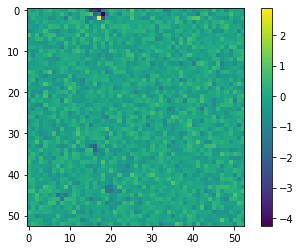

In [334]:
import copy 
dataArray  = copy.deepcopy(output[startNumber])
vmin, vmax = np.nanpercentile( np.log10(dataArray ) , [1., 99.9] )
print(np.min(dataArray) , np.max(dataArray), vmin, vmax ) 
plt.imshow(   output[startNumber]   )#, vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar()


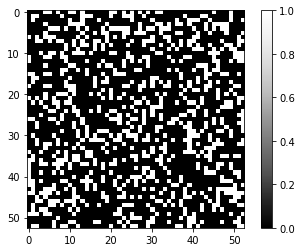

In [295]:
plt.imshow(  mask , vmin=0, vmax=1, cmap='Greys_r')
plt.colorbar()


## Code from Ben to make nice "stretch" diagram as the shifts are scaled up ...

In [346]:
output.shape, medsub.shape

((1162, 53, 53), (1162, 104, 148))

0 0.0 / 0.049
1 0.001 / 0.049
2 0.002 / 0.049
3 0.003 / 0.049
4 0.004 / 0.049
5 0.005 / 0.049
6 0.006 / 0.049
7 0.007 / 0.049
8 0.008 / 0.049
9 0.009000000000000001 / 0.049
10 0.01 / 0.049
11 0.011 / 0.049
12 0.012 / 0.049
13 0.013000000000000001 / 0.049
14 0.014 / 0.049
15 0.015 / 0.049
16 0.016 / 0.049
17 0.017 / 0.049
18 0.018000000000000002 / 0.049
19 0.019 / 0.049


/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


20 0.02 / 0.049
21 0.021 / 0.049
22 0.022 / 0.049
23 0.023 / 0.049
24 0.024 / 0.049
25 0.025 / 0.049
26 0.026000000000000002 / 0.049
27 0.027 / 0.049
28 0.028 / 0.049
29 0.029 / 0.049
30 0.03 / 0.049
31 0.031 / 0.049
32 0.032 / 0.049
33 0.033 / 0.049
34 0.034 / 0.049
35 0.035 / 0.049
36 0.036000000000000004 / 0.049
37 0.037 / 0.049
38 0.038 / 0.049
39 0.039 / 0.049
40 0.04 / 0.049
41 0.041 / 0.049
42 0.042 / 0.049
43 0.043000000000000003 / 0.049
44 0.044 / 0.049
45 0.045 / 0.049
46 0.046 / 0.049
47 0.047 / 0.049
48 0.048 / 0.049
49 0.049 / 0.049


<Figure size 576x432 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

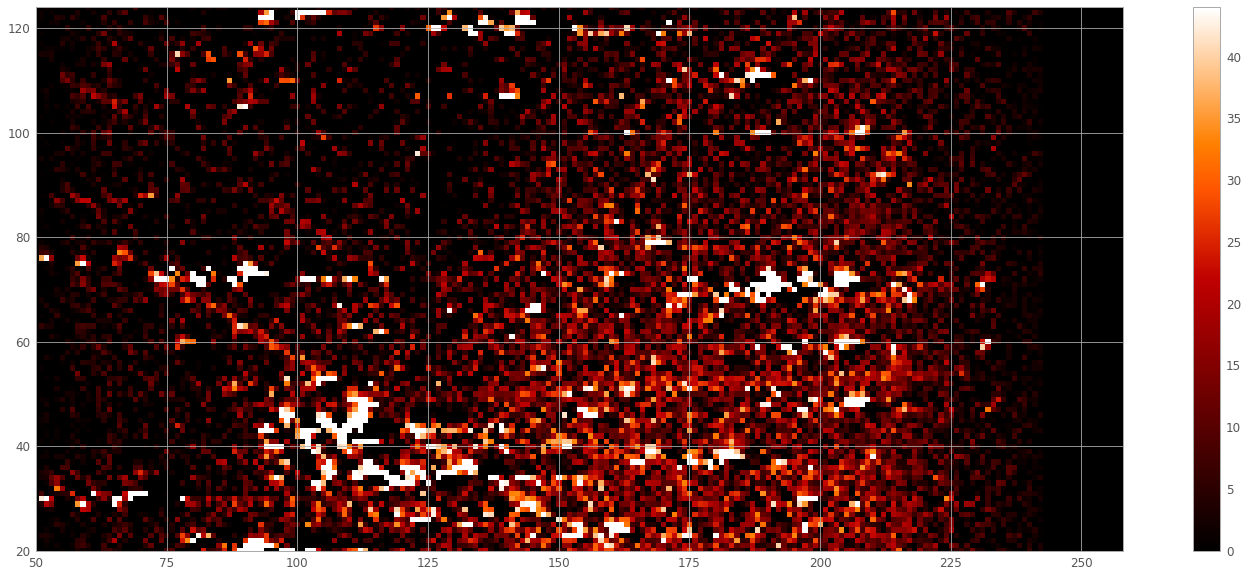

In [391]:
size = len(a[2].data[q])
steps = np.arange(0, 0.05, 0.001)
for j, step in enumerate(steps):
    print(j, step, "/", steps[-1])
    scaledoutput = np.zeros((size, 304,348))
    for i in range(size):
        shiftx = -1*np.int(np.round(x[i]-x[0], 0))
        shifty = -1*np.int(np.round(y[i]-y[0], 0))
        shiftx = -1*np.int(np.round(step*i, 0))
        scaledoutput[i, shifty+20:shifty+104+20, shiftx+100:shiftx+148+100] = medsub[i, :, :]
    outvar = np.sum(scaledoutput[100:500], axis=(0))
    outvar += np.sum(scaledoutput[600:1000], axis=(0))
    plt.clf()
    plt.figure(figsize=(25,10))
    plt.imshow(outvar, origin='lower', vmax=44, vmin=0)
    plt.xlim(50, 258)
    plt.ylim(20,124)
    plt.colorbar()
    plt.savefig('frames/%04i.png'%j)
    
    if j == 0 : 
        save_outvar = copy.deepcopy(outvar)

(104, 148) 11402


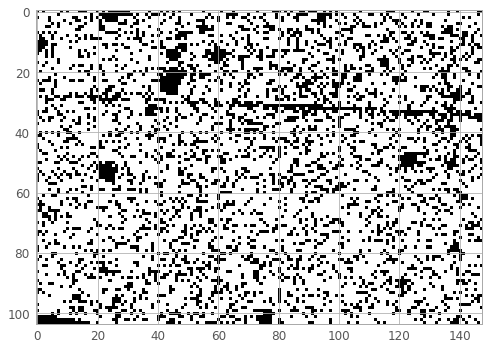

In [450]:
# indicees to be masked because they are too high in the median-subtracted slice 
summedArray = np.sum(medsub[100:500], axis=(0) ) 

indicees  = np.abs(summedArray) > 1.  # 2*np.nanmedian(dataArray)
print(indicees.shape, np.sum(indicees) ) 

# quick look ... 
#plt.hist( save_outvar.flatten() , bins=np.arange(-10,10,.03) )
#plt.imshow( np.log10(summedArray ) )# ,vmin=0,  vmax=4)
plt.imshow( indicees )# ,vmin=0,  vmax=4)
#plt.xlim(100,250)
#plt.ylim(0  ,150)
#plt.colorbar()

0 0.0 / 0.049
1 0.001 / 0.049
2 0.002 / 0.049
3 0.003 / 0.049
4 0.004 / 0.049
5 0.005 / 0.049
6 0.006 / 0.049
7 0.007 / 0.049
8 0.008 / 0.049
9 0.009000000000000001 / 0.049
10 0.01 / 0.049
11 0.011 / 0.049
12 0.012 / 0.049
13 0.013000000000000001 / 0.049
14 0.014 / 0.049
15 0.015 / 0.049
16 0.016 / 0.049
17 0.017 / 0.049
18 0.018000000000000002 / 0.049
19 0.019 / 0.049


/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


20 0.02 / 0.049
21 0.021 / 0.049
22 0.022 / 0.049
23 0.023 / 0.049
24 0.024 / 0.049
25 0.025 / 0.049
26 0.026000000000000002 / 0.049
27 0.027 / 0.049
28 0.028 / 0.049
29 0.029 / 0.049
30 0.03 / 0.049
31 0.031 / 0.049
32 0.032 / 0.049
33 0.033 / 0.049
34 0.034 / 0.049
35 0.035 / 0.049
36 0.036000000000000004 / 0.049
37 0.037 / 0.049
38 0.038 / 0.049
39 0.039 / 0.049
40 0.04 / 0.049
41 0.041 / 0.049
42 0.042 / 0.049
43 0.043000000000000003 / 0.049
44 0.044 / 0.049
45 0.045 / 0.049
46 0.046 / 0.049
47 0.047 / 0.049
48 0.048 / 0.049
49 0.049 / 0.049


<Figure size 576x432 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

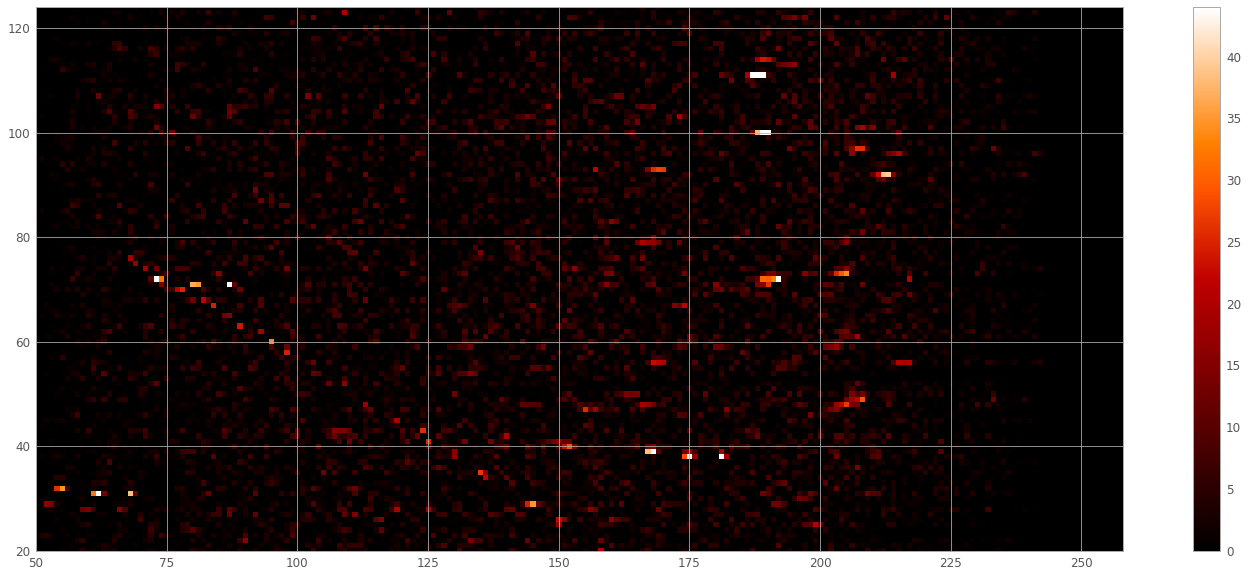

In [451]:

size = len(a[2].data[q])
steps = np.arange(0, 0.05, 0.001)
for j, step in enumerate(steps):
    print(j, step, "/", steps[-1])
    masked_scaledoutput = np.zeros((size, 304,348))
    for i in range(size):
        shiftx = -1*np.int(np.round(x[i]-x[0], 0))
        shifty = -1*np.int(np.round(y[i]-y[0], 0))
        shiftx = -1*np.int(np.round(step*i, 0))
        
        masked_medsub = medsub[i, :, :]
        masked_medsub[indicees] = 0 
        
        masked_scaledoutput[i, shifty+20:shifty+104+20, shiftx+100:shiftx+148+100] = masked_medsub
    outvar = np.sum(masked_scaledoutput[100:500], axis=(0))
    outvar += np.sum(masked_scaledoutput[600:1000], axis=(0))
    plt.clf()
    plt.figure(figsize=(25,10))
    plt.imshow(outvar, origin='lower', vmax=44, vmin=0)
    plt.xlim(50, 258)
    plt.ylim(20,124)
    plt.colorbar()
    plt.savefig('frames/masked_%04i.png'%j)
    


/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


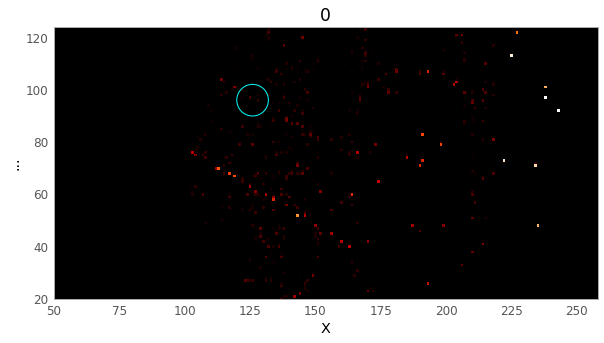

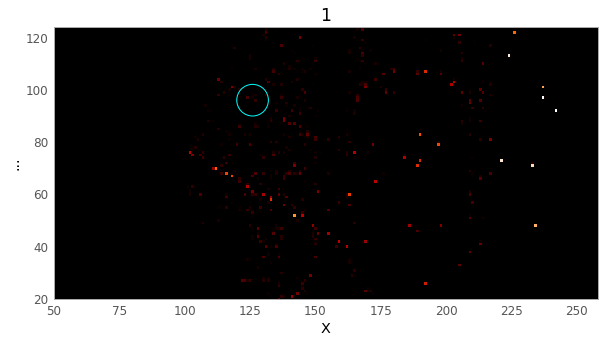

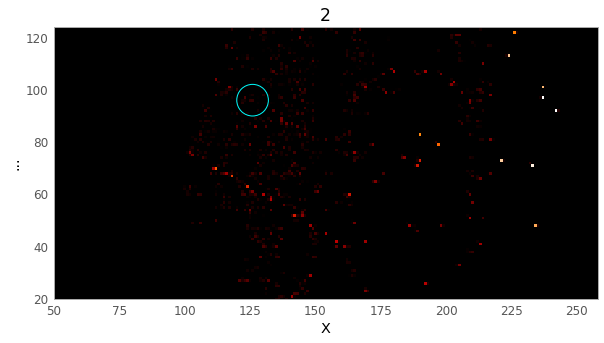

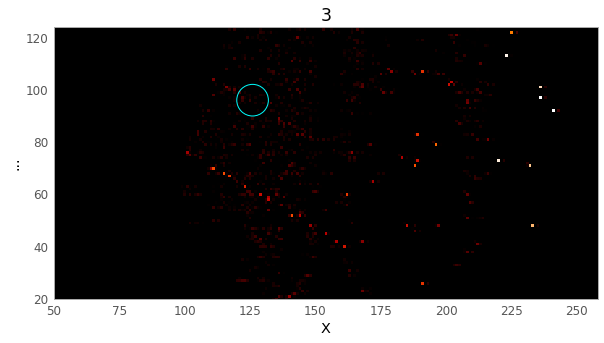

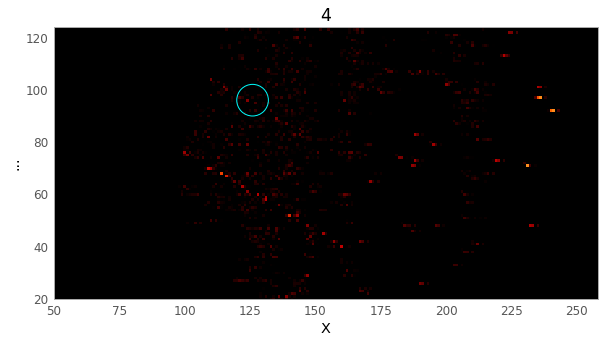

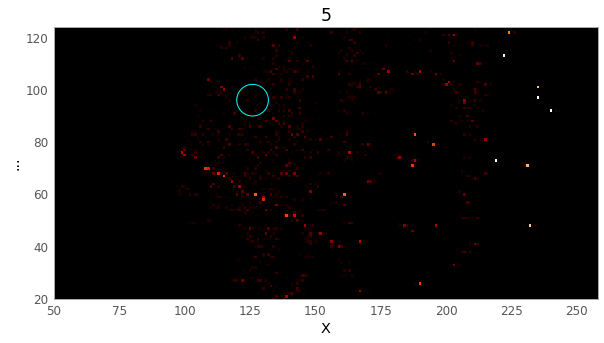

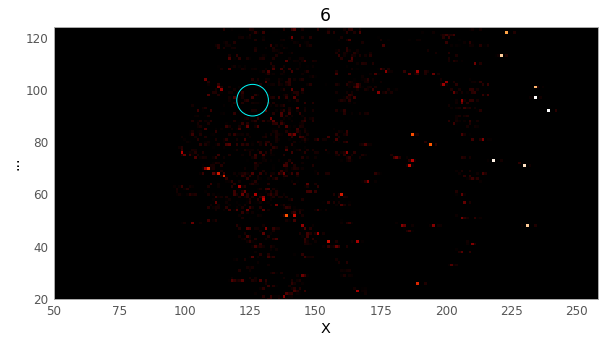

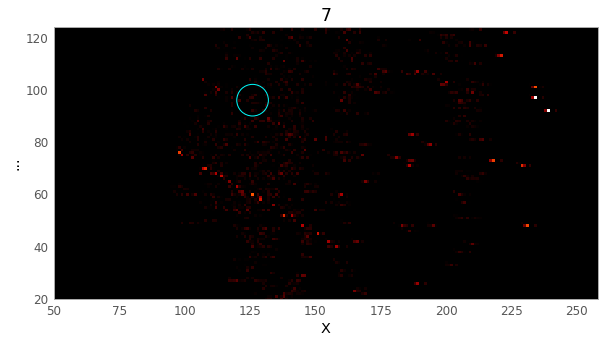

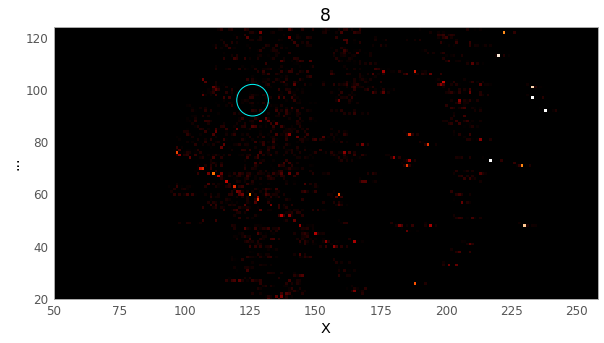

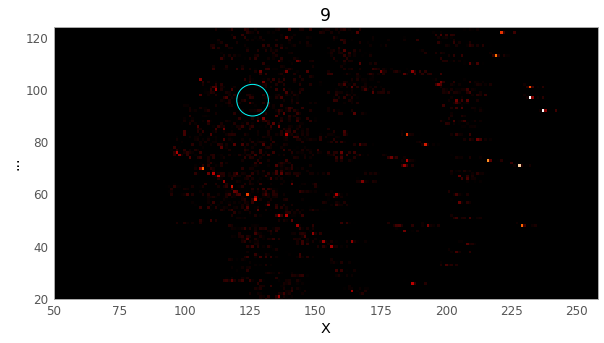

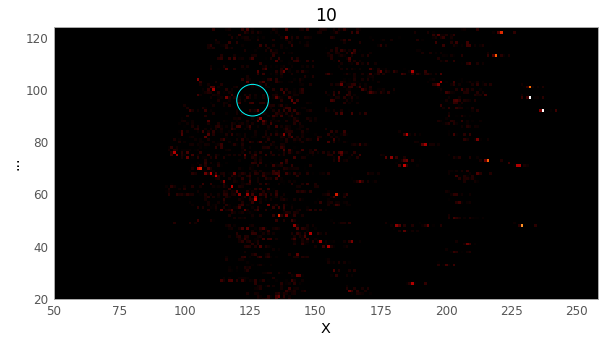

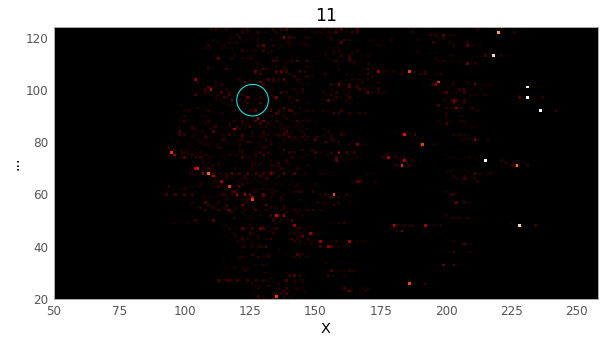

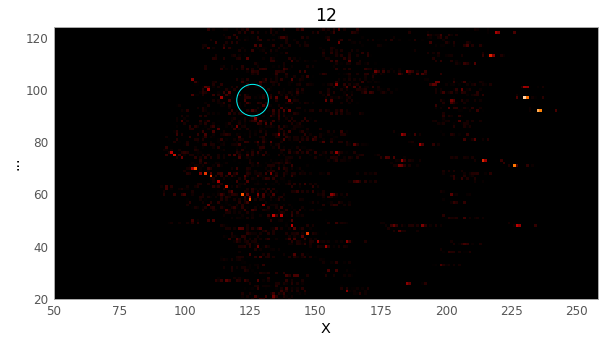

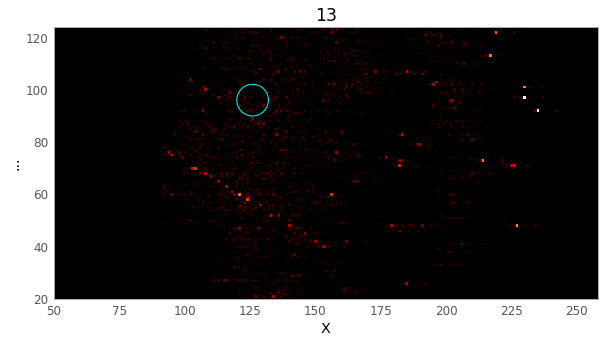

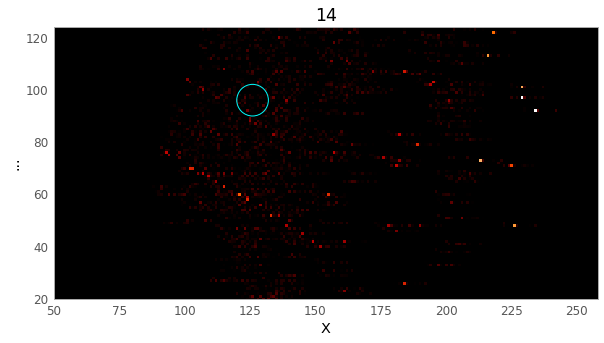

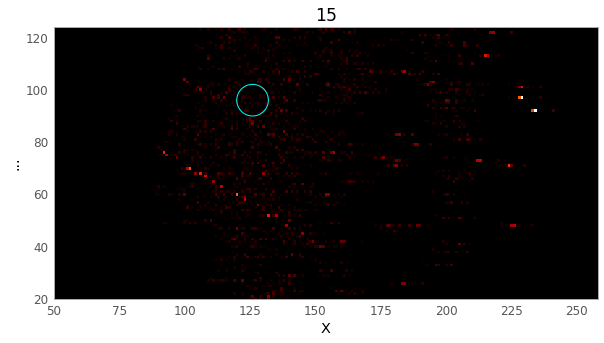

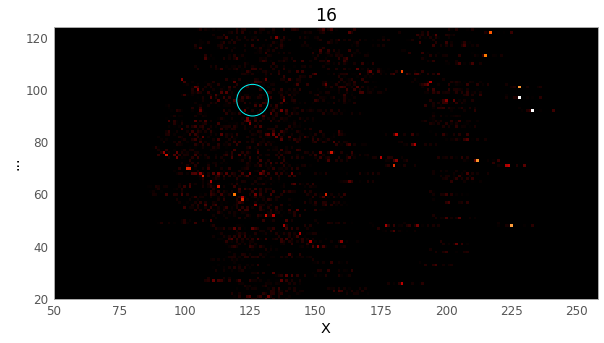

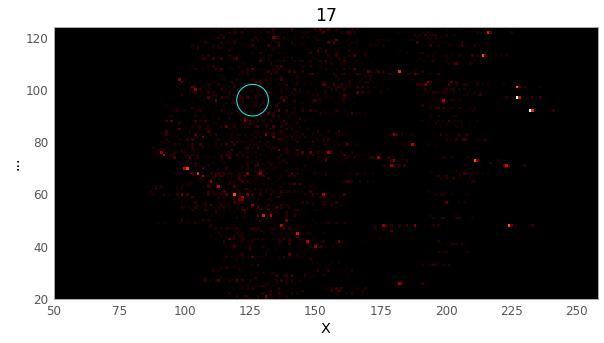

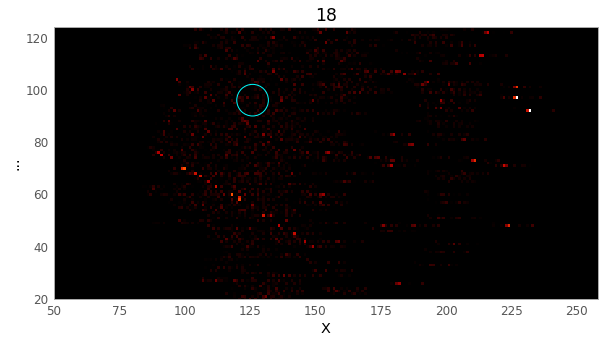

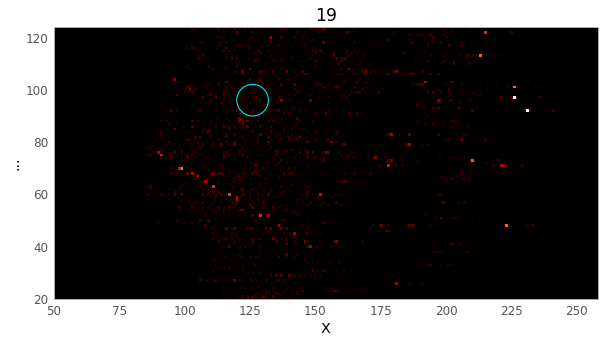

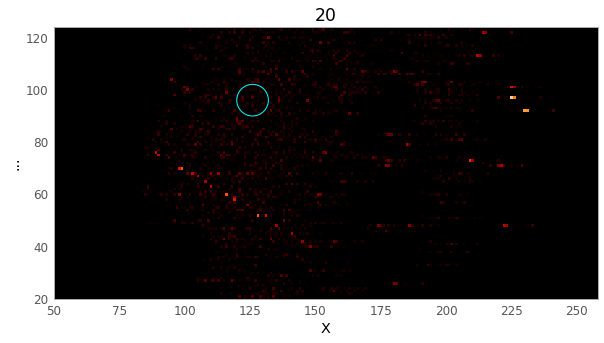

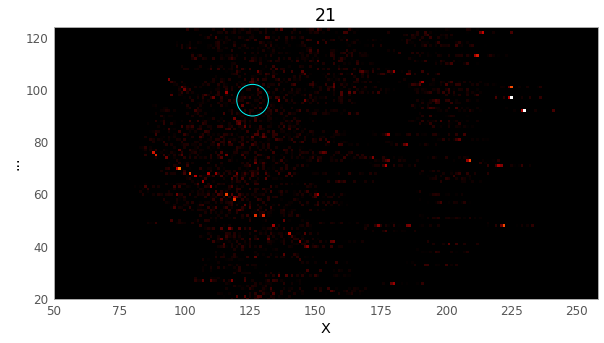

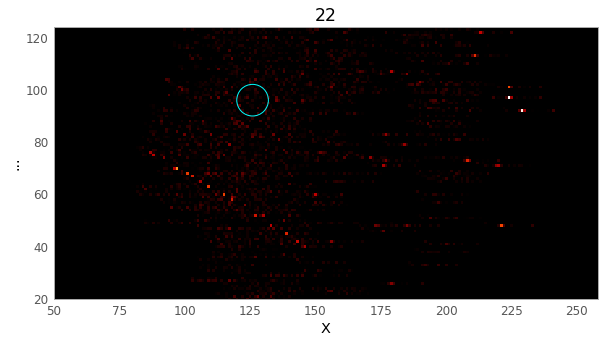

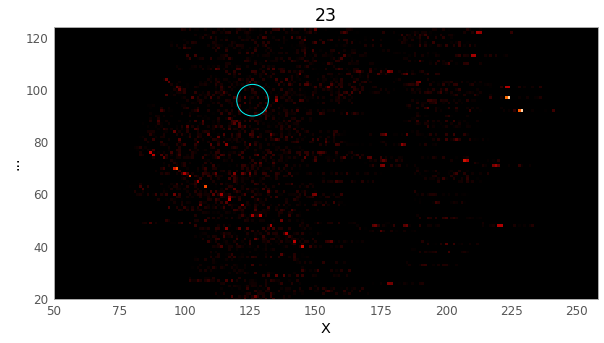

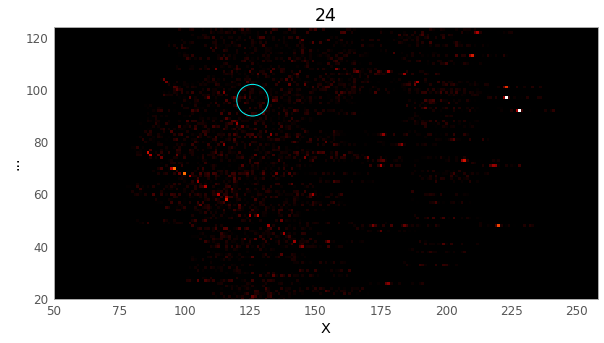

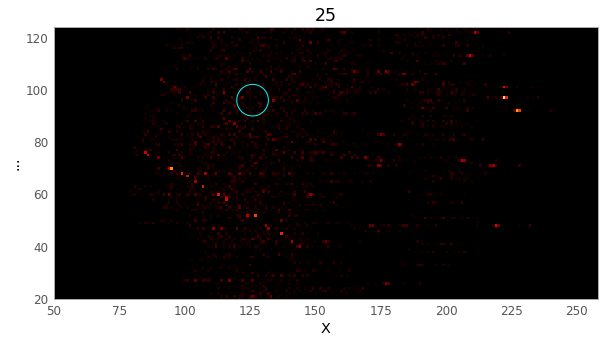

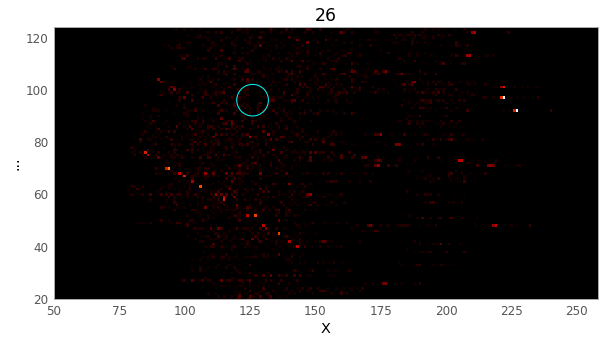

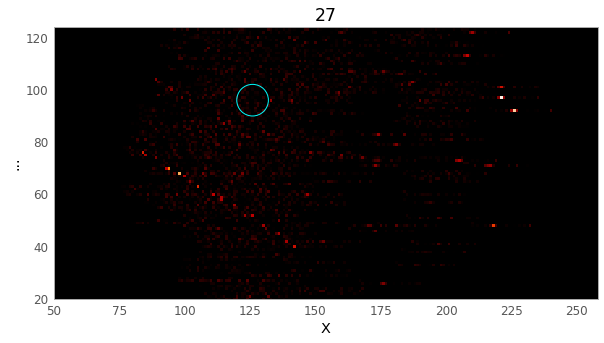

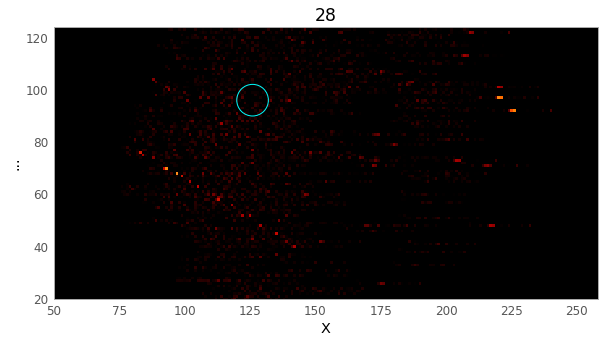

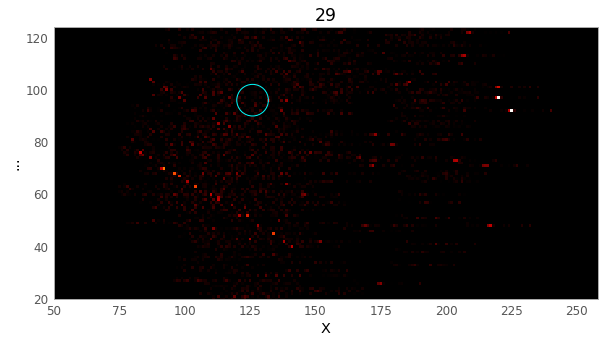

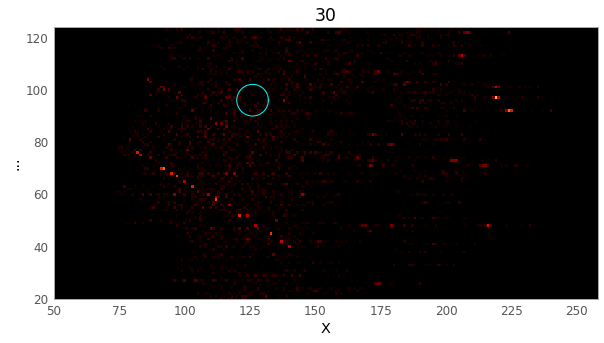

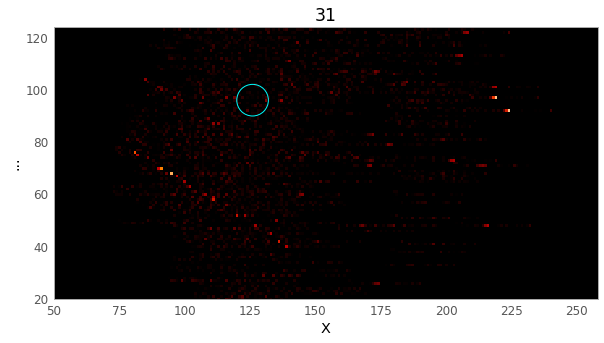

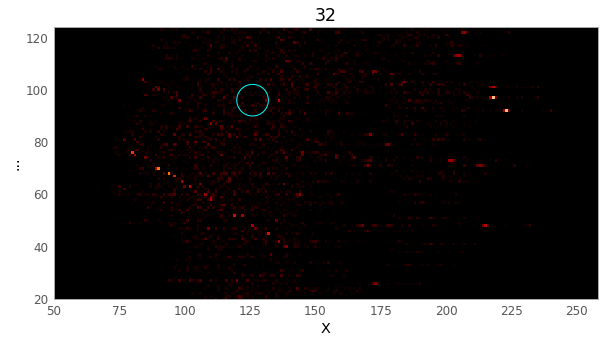

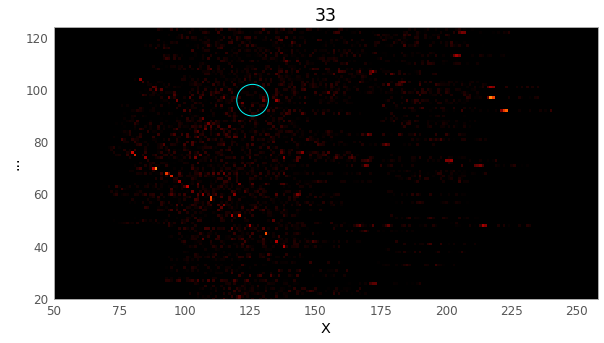

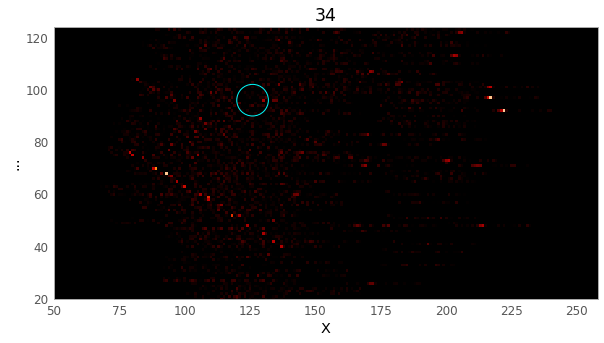

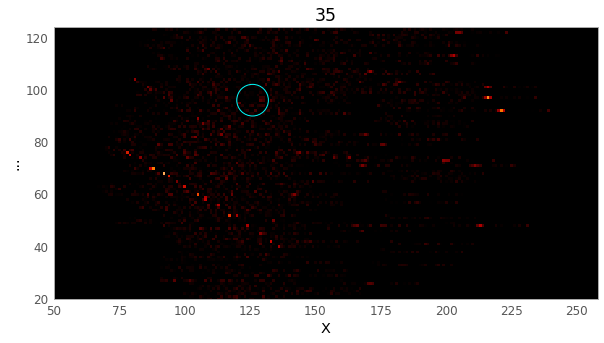

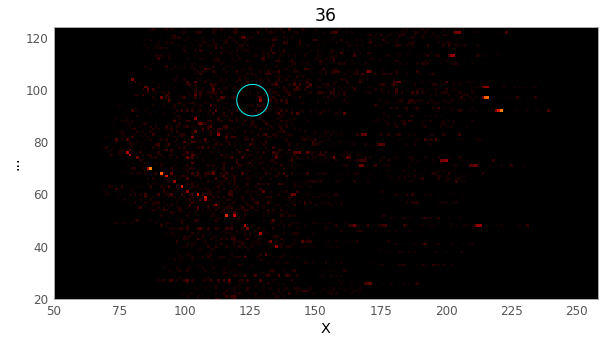

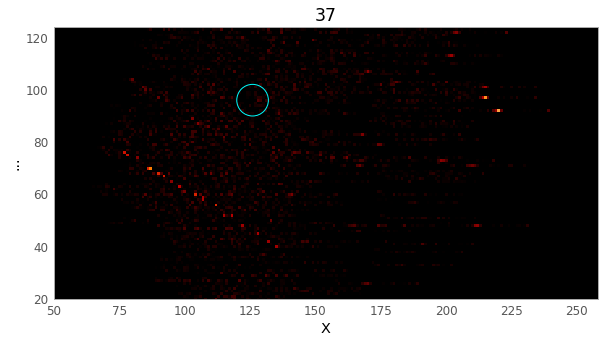

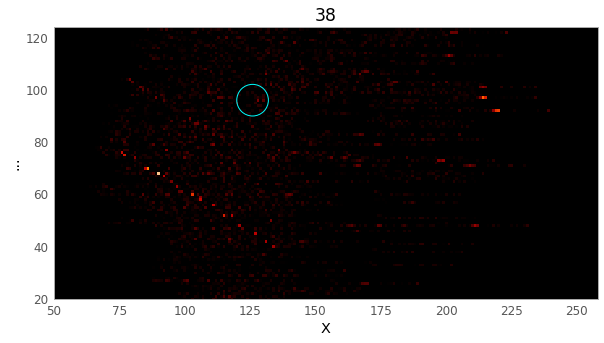

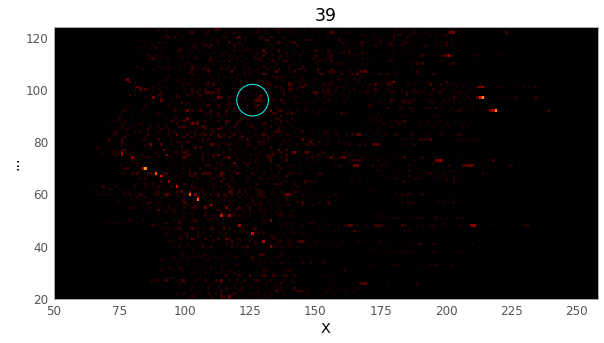

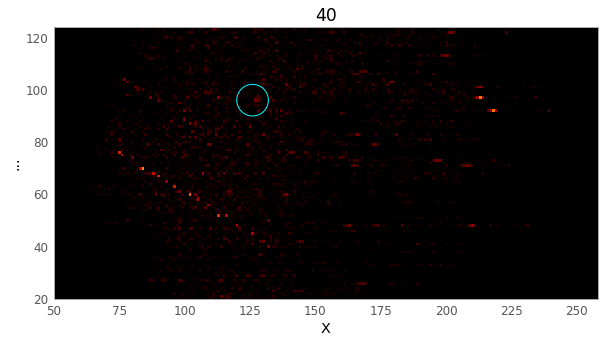

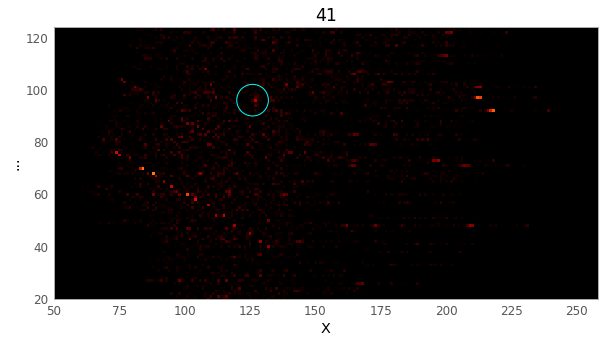

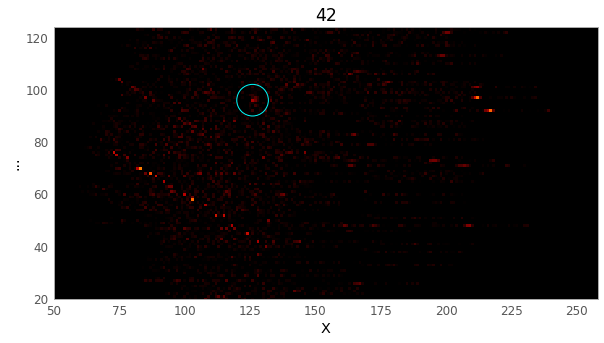

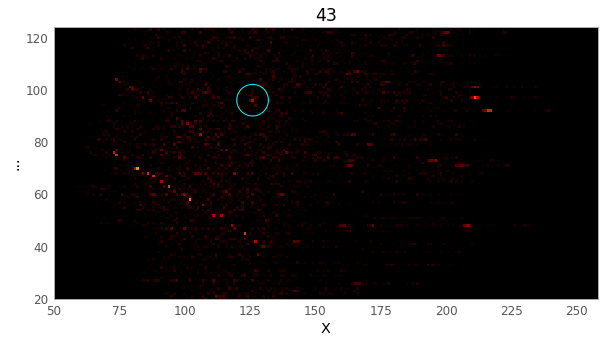

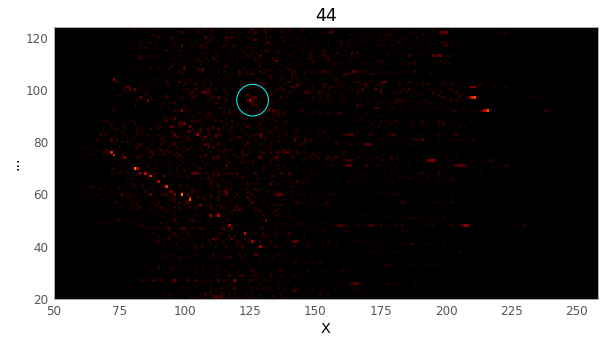

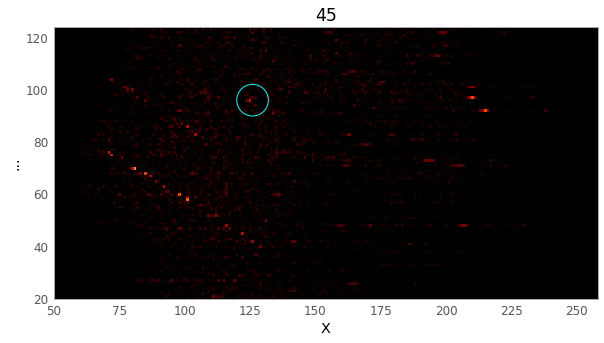

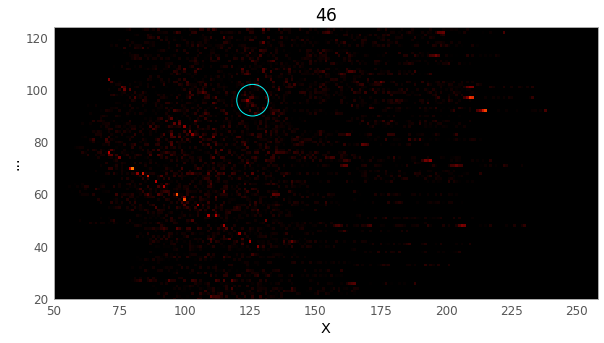

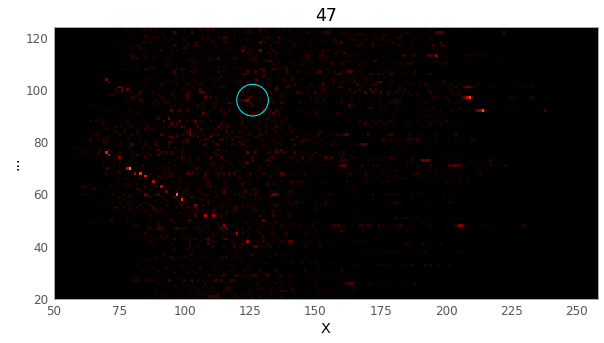

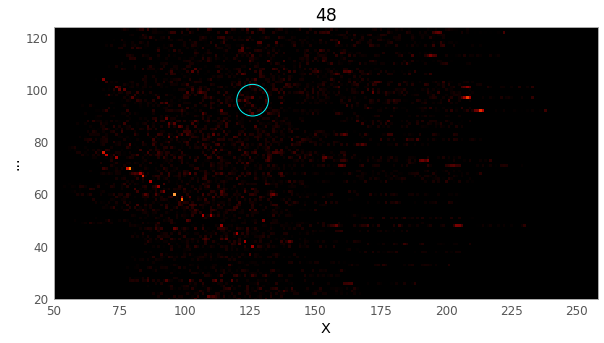

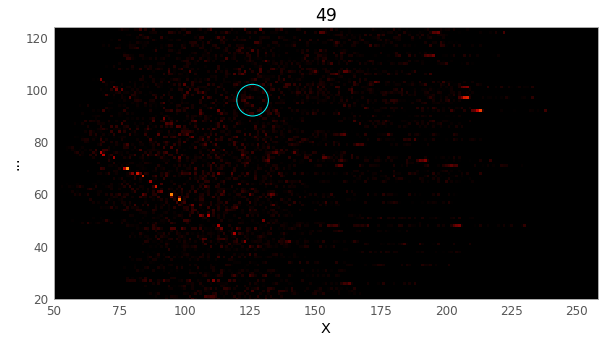

In [514]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

def plot_for_offset(j,step, xlims, ylims):
    
    # Make the plot 
    fig, ax = plt.subplots(figsize=(10,5))

    masked_scaledoutput = np.zeros((size, 304,348))
    for i in range(size):
        shiftx = -1*np.int(np.round(x[i]-x[0], 0))
        shifty = -1*np.int(np.round(y[i]-y[0], 0))
        shiftx = -1*np.int(np.round(step*i, 0))
        
        masked_medsub = medsub[i, :, :]
        masked_medsub[indicees] = 0 
        
        masked_scaledoutput[i, shifty+20:shifty+104+20, shiftx+100:shiftx+148+100] = masked_medsub
    outvar = np.sum(masked_scaledoutput[100:500], axis=(0))
    outvar += np.sum(masked_scaledoutput[600:1000], axis=(0))

    
    
    ax.imshow( outvar , origin='lower', vmin=0, vmax=40)
    ax.scatter( [126.],[96.],s=1000, alpha=0.99 , edgecolors='cyan' , facecolors='none', zorder=1111)

    ax.grid()
    ax.set(xlabel='X', ylabel='...', title='%r' % j)

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Used to return the plot as an image array
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

# Data for plotting
 

xlims = (50, 258)
ylims = (20,124)

# Make plots 
kwargs_write = {'fps':10.0, 'quantizer':'nq'}
imageio.mimsave('masked_output.gif', [plot_for_offset( j, step, xlims, ylims) for j, step in enumerate(steps)], fps=10)




# Now try to co-add and then plot the aggressively masked raw data 

0 0.0 / 0.049
1 0.001 / 0.049
2 0.002 / 0.049
3 0.003 / 0.049
4 0.004 / 0.049
5 0.005 / 0.049
6 0.006 / 0.049
7 0.007 / 0.049
8 0.008 / 0.049
9 0.009000000000000001 / 0.049
10 0.01 / 0.049
11 0.011 / 0.049
12 0.012 / 0.049
13 0.013000000000000001 / 0.049
14 0.014 / 0.049
15 0.015 / 0.049
16 0.016 / 0.049
17 0.017 / 0.049
18 0.018000000000000002 / 0.049
19 0.019 / 0.049


/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


20 0.02 / 0.049
21 0.021 / 0.049
22 0.022 / 0.049
23 0.023 / 0.049
24 0.024 / 0.049
25 0.025 / 0.049
26 0.026000000000000002 / 0.049
27 0.027 / 0.049
28 0.028 / 0.049
29 0.029 / 0.049
30 0.03 / 0.049
31 0.031 / 0.049
32 0.032 / 0.049
33 0.033 / 0.049
34 0.034 / 0.049
35 0.035 / 0.049
36 0.036000000000000004 / 0.049
37 0.037 / 0.049
38 0.038 / 0.049
39 0.039 / 0.049
40 0.04 / 0.049
41 0.041 / 0.049
42 0.042 / 0.049
43 0.043000000000000003 / 0.049
44 0.044 / 0.049
45 0.045 / 0.049
46 0.046 / 0.049
47 0.047 / 0.049
48 0.048 / 0.049
49 0.049 / 0.049


<Figure size 576x432 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

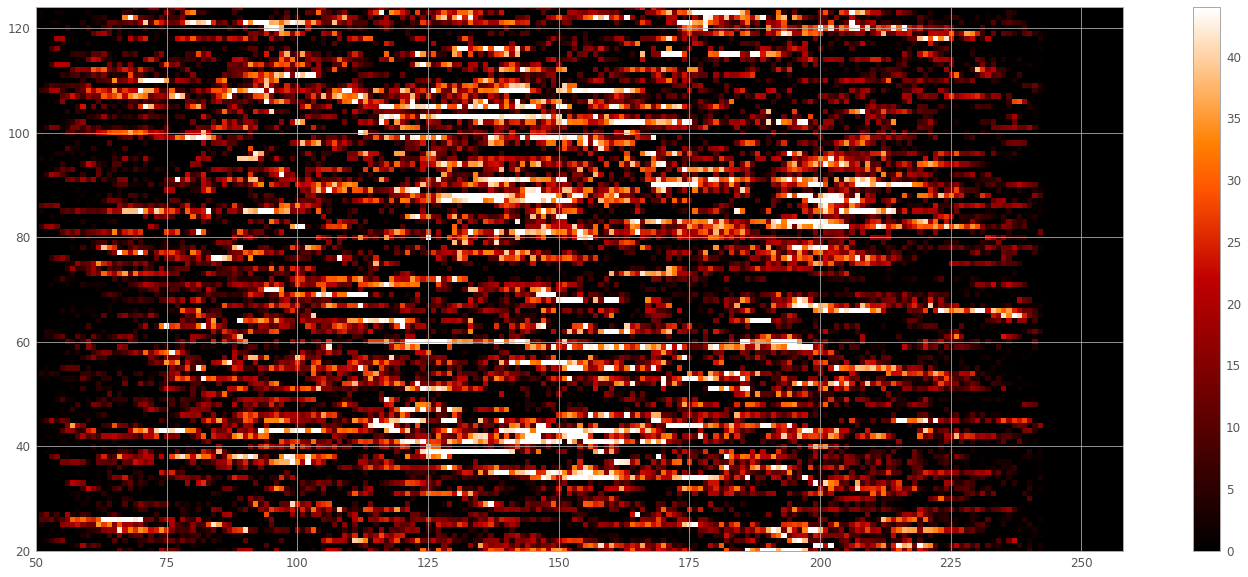

In [476]:


size = len(a[2].data[q])
steps = np.arange(0, 0.05, 0.001)
for j, step in enumerate(steps):
    print(j, step, "/", steps[-1])
    aggressively_masked_scaledoutput = np.zeros((size, 304,348))
    for i in range(size):
        shiftx = -1*np.int(np.round(x[i]-x[0], 0))
        shifty = -1*np.int(np.round(y[i]-y[0], 0))
        shiftx = -1*np.int(np.round(step*i, 0))
                
        aggressively_masked_scaledoutput[i, shifty+20:shifty+104+20, shiftx+100:shiftx+148+100] = aggressively_masked_medsub[i, :, :]
    outvar = np.sum(aggressively_masked_scaledoutput[100:500], axis=(0))
    outvar += np.sum(aggressively_masked_scaledoutput[600:1000], axis=(0))
    plt.clf()
    plt.figure(figsize=(25,10))
    plt.imshow(outvar, origin='lower', vmax=44, vmin=0)
    plt.xlim(50, 258)
    plt.ylim(20,124)
    plt.colorbar()
    plt.savefig('frames/aggressively_masked_%04i.png'%j)
    

